In [6]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from scipy import stats, spatial

from chdir import chdir
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from IPython.display import display, HTML, Image

In [27]:
rid2sig = pd.read_table('rid2symbol.txt',header=None)
ensg2sig = pd.read_table('ensg2symbol.txt',header=None)

genesymbols = np.unique(rid2sig.iloc[:,1].tolist() + ensg2sig.iloc[:,1].tolist())

In [28]:
KEGG = pd.read_table('KEGG_2016.txt',sep='\t',index_col=0, header=None,low_memory=False)
CHEA = pd.read_table('ChEA_2016.txt',sep='\t',index_col=0, header=None,low_memory=False)
ENCODE = pd.read_table('ENCODE_TF_ChIP-seq_2015.txt',sep='\t',index_col=0, header=None,low_memory=False)

JAK_STAT = KEGG.loc['Jak-STAT signaling pathway_Homo sapiens_hsa04630'].dropna().tolist()
TGF_beta = KEGG.loc['TGF-beta signaling pathway_Homo sapiens_hsa04350'].dropna().tolist()

tags = ['STAT1','STAT3','STAT5','SMAD2','SMAD3','GATA1','GATA2','JUN']

# regulatees = dict(zip(tags, [ np.array([]) for i in range(len(tags)) ]))
regulatees = dict(zip(tags, [ [] for i in range(len(tags)) ]))
chipseq = {}

for TF in regulatees.keys():
    for term in CHEA.index.values:
        if TF == term[:len(TF)]:            
            cell, organism = term.split('_')[-2:]
            if organism not in ['Mouse','mm9']: continue
            print TF, 'ChEA', cell, organism
            regulatees[TF] = np.unique(np.append(regulatees[TF], CHEA.loc[term].dropna().tolist()))
            chipseq[term] = CHEA.loc[term].dropna().tolist()
            
    for term in ENCODE.index.values:
        if TF == term[:len(TF)]:
            cell, organism = term.split('_')[-2:]
            if organism not in ['Mouse','mm9']: continue
            print TF, 'ChEA', cell, organism
            regulatees[TF] = np.unique(np.append(regulatees[TF], ENCODE.loc[term].dropna().tolist()))
            chipseq[term] = ENCODE.loc[term].dropna().tolist()
    
    print TF,'total =', len(regulatees[TF])
    print 
    
regulatees['SMAD2/3'] = np.unique(np.append(regulatees['SMAD2'], regulatees['SMAD3']))

del regulatees['SMAD2']
del regulatees['SMAD3']

print 'SMAD2/3 total =', len(regulatees['SMAD2/3'])

STAT5 ChEA MAMMARY-EPITHELIUM Mouse
STAT5 total = 1197

STAT3 ChEA MACROPHAGE Mouse
STAT3 ChEA MESCs Mouse
STAT3 ChEA MESCs Mouse
STAT3 ChEA IMN-ESCs Mouse
STAT3 ChEA MESCs Mouse
STAT3 ChEA ESCs Mouse
STAT3 ChEA CD4+T Mouse
STAT3 total = 7756

STAT1 total = 0

JUN ChEA MEL cell line mm9
JUN ChEA CH12.LX mm9
JUN ChEA CH12.LX mm9
JUN total = 2268

SMAD2 total = 0

SMAD3 ChEA ESCs Mouse
SMAD3 total = 1020

GATA2 ChEA HEMANGIOBLAST Mouse
GATA2 ChEA HPC-7 Mouse
GATA2 ChEA BM-HSCs Mouse
GATA2 ChEA G1ME Mouse
GATA2 ChEA G1E mm9
GATA2 ChEA G1E-ER4 mm9
GATA2 total = 6082

GATA1 ChEA HPCs Mouse
GATA1 ChEA MEL Mouse
GATA1 ChEA MEL86 Mouse
GATA1 ChEA G1ME Mouse
GATA1 ChEA G1E-ER4 mm9
GATA1 ChEA MEL cell line mm9
GATA1 ChEA erythroblast mm9
GATA1 ChEA megakaryocyte mm9
GATA1 total = 8830

SMAD2/3 total = 1020


In [34]:
marrow_data = pd.read_table('GATA1_marrow_profile.txt',sep='\t',index_col=0)
spleen_data = pd.read_table('GATA1_spleen_profile.txt',sep='\t',index_col=0)

pvals = ['cd1.Detection Pval','cd2.Detection Pval','cd3.Detection Pval',
         'gat1.Detection Pval','gat2.Detection Pval','gat3.Detection Pval']
signal = ['cd1.AVG_Signal','cd2.AVG_Signal','cd3.AVG_Signal',
          'gat1.AVG_Signal','gat2.AVG_Signal','gat3.AVG_Signal']
samples = [x.split('.')[0] for x in signal]

marrow_data = marrow_data[signal]
spleen_data = spleen_data[signal]
marrow_data.columns = samples
spleen_data.columns = samples

marrow_data[marrow_data < 0] = 0
spleen_data[spleen_data < 0] = 0

print "Marrow:"
print marrow_data.shape
marrow_data = marrow_data.loc[ [x for x in marrow_data.index.values if x in genesymbols ] ]
print marrow_data.shape
marrow_data = marrow_data[np.max(marrow_data,axis=1) > 1.5]
print marrow_data.shape

print "Spleen:"
print spleen_data.shape
print marrow_data.shape
marrow_data = marrow_data.loc[ [x for x in marrow_data.index.values if x in genesymbols ] ]
spleen_data = spleen_data[np.max(spleen_data,axis=1) > 1.5]
print spleen_data.shape

# marrow_data.d
# spleen_data[spleen_data < 0] = 0

(30854, 6)
(13288, 6)
(11863, 6)
(30853, 6)
(25003, 6)


In [7]:
def chdir_data(control, treated, genelist):
#     avg_control = np.mean(control,axis=1)
#     avg_treated = np.mean(treated,axis=1)
    
    #     tstat = np.abs((avg_control - avg_treated)/
#                    (np.sqrt(np.var(control,axis=1)/3 + np.var(treated,axis=1)/3)))
    
#     sderr = np.sqrt((np.var(control,axis=1) + np.var(treated,axis=1))/2)

#     tstat = (avg_control - avg_treated)/(sderr*np.sqrt(2/3))
#     pvals = [ 2*stats.t.sf(np.abs(x), 4) for x in tstat ]
    
    tstat, pvals = stats.ttest_ind(control, treated, axis=1, equal_var=False)
        
    [cdGenes,cdVector] = chdir(control, treated, genelist)
    return pd.DataFrame(zip(cdVector, tstat, pvals), columns = ['exp','t-stat','p-value'], index=cdGenes)

def logfc_data(control, treated, genelist):
    avg_control = np.mean(control,axis=1)
    avg_treated = np.mean(treated,axis=1)
    
    #     tstat = np.abs((avg_control - avg_treated)/
#                    (np.sqrt(np.var(control,axis=1)/3 + np.var(treated,axis=1)/3)))
    
#     sderr = np.sqrt((np.var(control,axis=1) + np.var(treated,axis=1))/2)
#     tstat = np.abs(avg_control - avg_treated)/(sderr*np.sqrt(2/3))
#     pvals = [ 2*stats.t.sf(np.abs(x), 4) for x in tstat ]
    tstat, pvals = stats.ttest_ind(control, treated, axis=1, equal_var=False)
    
    logfc = np.log2((avg_treated+0.05)/(avg_control+0.05))
    
    return pd.DataFrame( zip(logfc, tstat, pvals), columns = ['exp','t-stat','p-value'], index=genelist)

In [8]:
control = ['cd1','cd2','cd3']
treated = ['gat1','gat2','gat3']

marrow_cd = chdir_data(marrow_data[control].values,
                       marrow_data[treated].values,
                       marrow_data.index.values)

spleen_cd = chdir_data(spleen_data[control].values,
                       spleen_data[treated].values,
                       spleen_data.index.values)

marrow_fc = logfc_data(marrow_data[control].values,
                       marrow_data[treated].values,
                       marrow_data.index.values)

spleen_fc = logfc_data(spleen_data[control].values,
                       spleen_data[treated].values,
                       spleen_data.index.values)

marrow_fc
std = 1.13486210661
pct = 1475
marrow_cd
std = 0.000614112839283
pct = 1611
spleen_fc
std = 1.1494476658
pct = 1619
spleen_cd
std = 0.000695535224066
pct = 1294


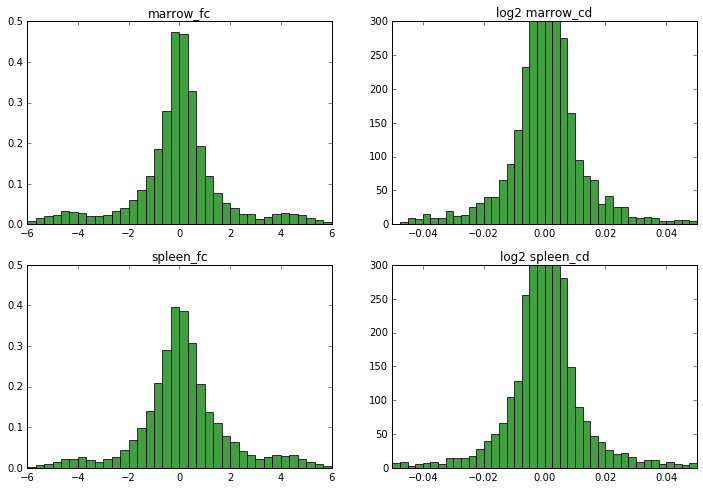

In [9]:
n_degs = 1000

pct = 0.1 # trim percentage

fig = plt.figure(figsize=(12, 8), dpi=80)

# Plot histograms of data

fc_cut = 1.00
cd_cut = 0.0001

fc_p = 0.1
cd_p = 0.1

## ONE ##

name = 'marrow_fc'
df = marrow_fc.reindex(marrow_fc.abs().sort_values('exp',ascending=False).index)
df.to_csv(name+'.txt',sep='\t')
marrow_fc_degs = df[ (df['exp'].abs().values > fc_cut) & (df['p-value'].values < fc_p)]
vals = df['exp'].values

fig.add_subplot(2,2,1)
plt.hist(vals, np.arange(-10, 10 + 1/3.0, 1/3.0),
    normed=1, facecolor='green', alpha=0.75)
plt.title(name)
plt.axis([-6, 6, 0, 0.5])

print name
print 'std =',np.std(vals[-int(len(df)*(1.0-pct)):])
print 'pct =',len(marrow_fc_degs) #/float(len(df))

## TWO ##

name = 'marrow_cd'
df = marrow_cd.reindex(marrow_cd.abs().sort_values('exp',ascending=False).index)
df.to_csv(name+'.txt',sep='\t')
marrow_cd_degs = df[ (df['exp'].abs().values > cd_cut) & (df['p-value'].values < cd_p)]
# vals = df['exp'].values
vals = np.log2(df['exp'].values + 1.0)

fig.add_subplot(2,2,2)
plt.hist(vals, np.arange(-0.1, 0.1 + 0.0025, 0.0025), facecolor='green', alpha=0.75)
# plt.hist(df['exp'].values, np.arange(-0.1, 0.1 + 0.001, 0.001),
#     normed=1, facecolor='green', alpha=0.75)
plt.title('log2 '+name)
# plt.axis([-0.02, 0.02, 0, 50])
plt.axis([-0.05, 0.05, 0, 300])

print name
print 'std =',np.std(vals[-int(len(df)*(1.0-pct)):])
print 'pct =',len(marrow_cd_degs) #/float(len(df))

## THREE ##

name = 'spleen_fc'
df = spleen_fc.reindex(spleen_fc.abs().sort_values('exp',ascending=False).index)
df.to_csv(name+'.txt',sep='\t')
spleen_fc_degs = df[ (df['exp'].abs().values > fc_cut) & (df['p-value'].values < fc_p)]
vals = df['exp'].values

fig.add_subplot(2,2,3)
plt.hist(df['exp'].values, np.arange(-10, 10 + 1/3.0, 1/3.0),
    normed=1, facecolor='green', alpha=0.75)
plt.title(name)
plt.axis([-6, 6, 0, 0.5])

print name
print 'std =',np.std(vals[-int(len(df)*(1.0-pct)):] )
print 'pct =',len(spleen_fc_degs) #/float(len(df))

## FOUR ##

name = 'spleen_cd'
df = spleen_cd.reindex(spleen_cd.abs().sort_values('exp',ascending=False).index)
df.to_csv(name+'.txt',sep='\t')
spleen_cd_degs = df[ (df['exp'].abs().values > cd_cut) & (df['p-value'].values < cd_p)]
# vals = df['exp'].values
vals = np.log2(df['exp'].values + 1.0)

fig.add_subplot(2,2,4)
plt.hist(vals, np.arange(-0.1, 0.1 + 0.0025, 0.0025), facecolor='green', alpha=0.75)
# plt.hist(df['exp'].values, np.arange(-0.1, 0.1 + 0.001, 0.001),
#     normed=1, facecolor='green', alpha=0.75)
plt.title('log2 '+name)
# plt.axis([-0.02, 0.02, 0, 50])
plt.axis([-0.05, 0.05, 0, 300])

print name
print 'std =',np.std(vals[-int(len(df)*(1.0-pct)):])
print 'pct =',len(spleen_cd_degs) #/float(len(df))

# print marrow_cd_degs.intersect(marrow_fc_degs)

# print float(len(set(marrow_cd_degs) & set(marrow_fc_degs)))/float(len(set(marrow_cd_degs) | set(marrow_fc_degs)))

In [232]:
marrow_fc_degs.to_csv('marrow_fc_DEGs.txt', sep='\t')
marrow_cd_degs.to_csv('marrow_cd_DEGs.txt', sep='\t')
spleen_fc_degs.to_csv('spleen_fc_DEGs.txt', sep='\t')
spleen_cd_degs.to_csv('spleen_cd_DEGs.txt', sep='\t')

marrow_fc_1000 = marrow_fc_degs.index.values[:1000]
marrow_cd_1000 = marrow_cd_degs.index.values[:1000]
spleen_fc_1000 = spleen_fc_degs.index.values[:1000]
spleen_cd_1000 = spleen_cd_degs.index.values[:1000]

print spleen_fc_degs.index.values[1000]

np.savetxt('marrow_fc_top1000.txt', marrow_fc_1000, fmt='%s')
np.savetxt('marrow_cd_top1000.txt', marrow_cd_1000, fmt='%s')
np.savetxt('spleen_fc_top1000.txt', spleen_fc_1000, fmt='%s')
np.savetxt('spleen_cd_top1000.txt', spleen_cd_1000, fmt='%s')

LOC100046143


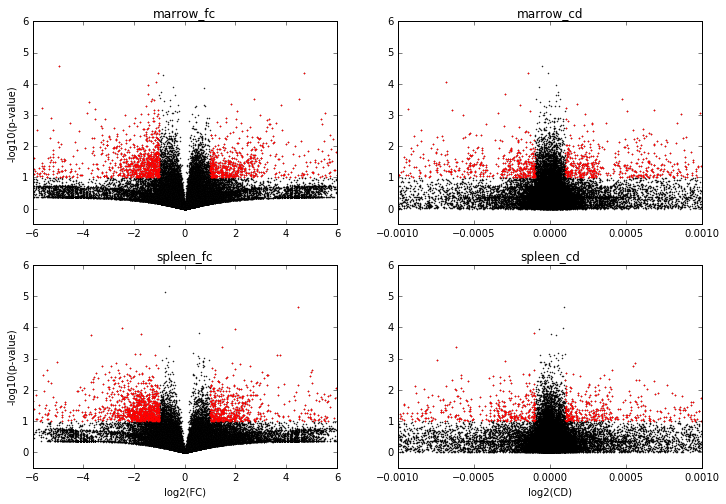

                exp    t-stat   p-value
LOC381808 -0.054498  2.345354  0.080075
YBX3      -0.054837  2.351502  0.083180
FOSB      -0.063699  3.476991  0.038656
CD74      -0.069620  3.361345  0.061404
H2-EA     -0.121245  2.846370  0.086059


In [10]:
fig = plt.figure(figsize=(12, 8), dpi=80)

name = 'marrow_fc'
fig.add_subplot(2,2,1)
df = marrow_fc
df2 = marrow_fc[(np.abs(marrow_fc['exp']) > fc_cut) & (marrow_fc['p-value'] < fc_p)]
df2.to_csv(name+'_DEGs_filt.txt',sep='\t')
plt.scatter(df['exp'].values, -np.log10(df['p-value'].values),s=1,c='gray',marker='.')
plt.scatter(df2['exp'].values, -np.log10(df2['p-value'].values),s=1,c='red',marker='x')
plt.ylabel('-log10(p-value)')
plt.title(name)
plt.axis([-6, 6, -0.5, 6])

name = 'marrow_cd'
fig.add_subplot(2,2,2)
df = marrow_cd
df2 = marrow_cd[(np.abs(marrow_cd['exp']) > cd_cut) & (marrow_cd['p-value'] < cd_p)]
df2.to_csv(name+'_DEGs_filt.txt',sep='\t')
plt.scatter(df['exp'].values, -np.log10(df['p-value'].values),s=1,c='gray',marker='.')
plt.scatter(df2['exp'].values, -np.log10(df2['p-value'].values),s=1,c='red',marker='x')
plt.title(name)
plt.axis([-0.001, 0.001, -0.5, 6])

name = 'spleen_fc'
fig.add_subplot(2,2,3)
df = spleen_fc
df2 = spleen_fc[(np.abs(spleen_fc['exp']) > fc_cut) & (spleen_fc['p-value'] < fc_p)]
df2.to_csv(name+'_DEGs_filt.txt',sep='\t')
plt.scatter(df['exp'].values, -np.log10(df['p-value'].values),s=1,c='gray',marker='.')
plt.scatter(df2['exp'].values, -np.log10(df2['p-value'].values),s=1,c='red',marker='x')
plt.xlabel('log2(FC)')
plt.ylabel('-log10(p-value)')
plt.title(name)
plt.axis([-6, 6, -0.5, 6])

name = 'spleen_cd'
fig.add_subplot(2,2,4)
df = spleen_cd
df2 = spleen_cd[(np.abs(spleen_cd['exp']) > cd_cut) & (spleen_cd['p-value'] < cd_p)]
df2.to_csv(name+'_DEGs_filt.txt',sep='\t')
plt.scatter(df['exp'].values, -np.log10(df['p-value'].values),s=1,c='gray',marker='.')
plt.scatter(df2['exp'].values, -np.log10(df2['p-value'].values),s=1,c='red',marker='x')
plt.xlabel('log2(CD)')
plt.title(name)
plt.axis([-0.001, 0.001, -0.5, 6])

plt.show()

print spleen_cd[(spleen_cd['exp'] < -0.05) & (spleen_cd['p-value'] < 0.1)]

In [277]:
spleen_cd_set = set(marrow_fc_1000)
marrow_cd_set = set(marrow_cd_1000)
spleen_fc_set = set(spleen_fc_1000)
marrow_fc_set = set(marrow_fc_1000)

for TF in regulatees.keys():
    print TF,'cd v. fc'
    
    cd_overlap = len(spleen_cd_set.intersection(regulatees[TF]))
    cd_total = float(len(spleen_cd_set.union(regulatees[TF])))
    fc_overlap = len(spleen_fc_set.intersection(regulatees[TF]))
    fc_total = float(len(spleen_fc_set.union(regulatees[TF])))
    
    print "SPLEEN:",cd_overlap,'('+str(cd_overlap/cd_total)[:6]+'%) v.',fc_overlap,'('+str(fc_overlap/fc_total)[:6]+'%)'

    cd_overlap = len(marrow_cd_set.intersection(regulatees[TF]))
    cd_total = float(len(marrow_cd_set.union(regulatees[TF])))
    fc_overlap = len(marrow_fc_set.intersection(regulatees[TF]))
    fc_total = float(len(marrow_fc_set.union(regulatees[TF])))
    
    print "MARROW:",cd_overlap,'('+str(cd_overlap/cd_total)[:6]+'%) v.',fc_overlap,'('+str(fc_overlap/fc_total)[:6]+'%)'
    print
    
    cd_overlap = len(spleen_cd_set.intersection(regulatees[TF]))
    cd_total = float(len(spleen_cd_set.union(regulatees[TF])))
    fc_overlap = len(spleen_fc_set.intersection(regulatees[TF]))
    fc_total = float(len(spleen_fc_set.union(regulatees[TF])))
    


STAT5 cd v. fc
SPLEEN: 41 (0.0114%) v. 60 (0.0168%)
MARROW: 119 (0.0339%) v. 41 (0.0114%)

STAT3 cd v. fc
SPLEEN: 253 (0.0175%) v. 272 (0.0188%)
MARROW: 442 (0.0310%) v. 253 (0.0175%)

STAT1 cd v. fc
SPLEEN: 103 (0.0167%) v. 110 (0.0178%)
MARROW: 209 (0.0345%) v. 103 (0.0167%)

JUN cd v. fc
SPLEEN: 231 (0.0168%) v. 241 (0.0176%)
MARROW: 468 (0.0347%) v. 231 (0.0168%)

TGF-beta cd v. fc
SPLEEN: 2 (0.0018%) v. 4 (0.0037%)
MARROW: 0 (0.0%) v. 2 (0.0018%)

GATA2 cd v. fc
SPLEEN: 245 (0.0206%) v. 233 (0.0196%)
MARROW: 397 (0.0339%) v. 245 (0.0206%)

JAK-STAT cd v. fc
SPLEEN: 7 (0.0060%) v. 4 (0.0034%)
MARROW: 8 (0.0069%) v. 7 (0.0060%)

SMAD2/3 cd v. fc
SPLEEN: 158 (0.0179%) v. 188 (0.0213%)
MARROW: 257 (0.0294%) v. 158 (0.0179%)

GATA1 cd v. fc
SPLEEN: 261 (0.0209%) v. 243 (0.0194%)
MARROW: 500 (0.0408%) v. 261 (0.0209%)



In [278]:
gene = 'SMAD2'

print gene in spleen_cd_degs.index.values.tolist()
print spleen_cd.loc[gene]

print gene in spleen_fc_degs.index.values.tolist()
print spleen_fc.loc[gene]

print gene in marrow_cd_degs.index.values.tolist()
print marrow_cd.loc[gene]

print gene in marrow_fc_degs.index.values.tolist()
print marrow_fc.loc[gene]

False
exp        0.003205
t-stat     0.194276
p-value    0.862082
Name: SMAD2, dtype: float64
True
exp        2.602954
t-stat    -5.755531
p-value    0.015226
Name: SMAD2, dtype: float64
False
exp        0.002436
t-stat    -1.245385
p-value    0.339110
Name: SMAD2, dtype: float64
True
exp        1.946508
t-stat    -3.456198
p-value    0.041351
Name: SMAD2, dtype: float64


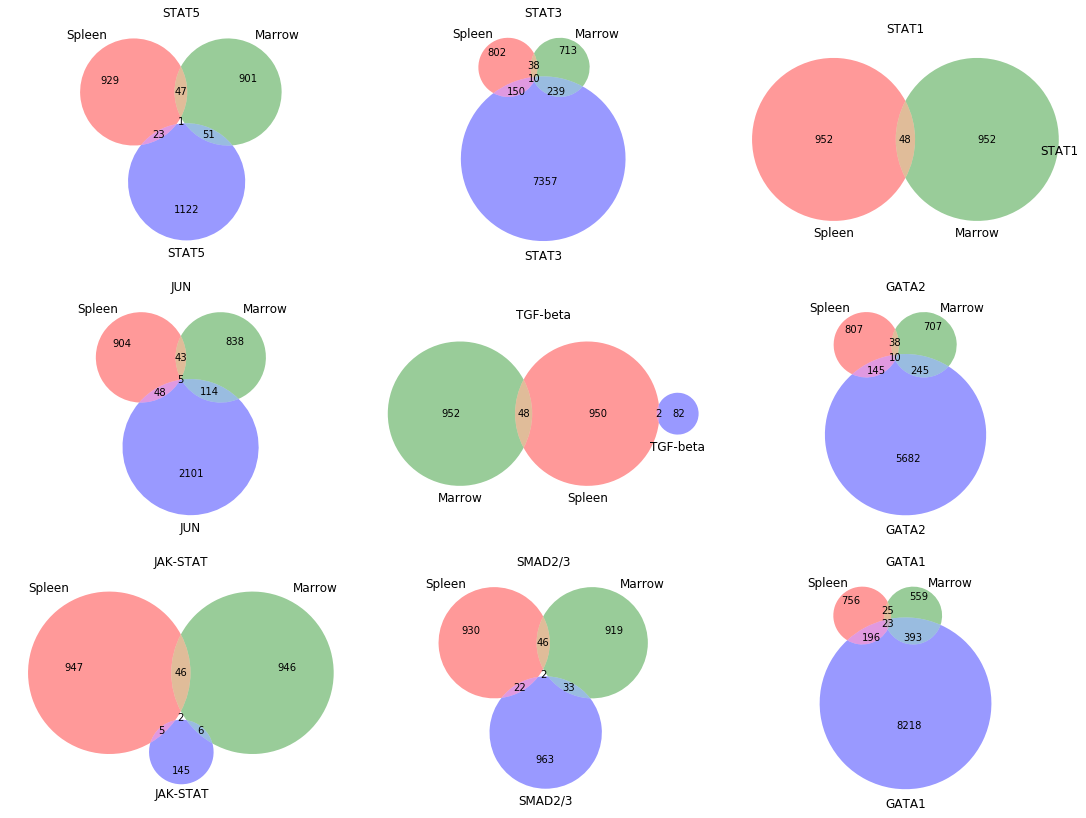

In [295]:
from matplotlib_venn import venn3

fig = plt.figure(figsize=(15, 15), dpi=80)
# fig = plt.figure(figsize=(15, 75), dpi=80)

# terms_dict = chipseq
terms_dict = regulatees

terms_dict['JAK-STAT'] = JAK_STAT
terms_dict['TGF-beta'] = TGF_beta

# print len(regulatees.keys())

for i in range(len(terms_dict.keys())):
    
    term = terms_dict.keys()[i]
    
    try:
        tf = term.split('_')[0]
        tissue = term.split('_')[-2]
        display_name = tf+' ('+tissue+')'
    except:
        display_name = term
    
#     fig.add_subplot(25,3,i+1)
    fig.add_subplot(4,3,i+1)

    venn3([spleen_cd_set, marrow_cd_set, set(terms_dict[term])],('Spleen','Marrow',display_name))
    plt.title(term)
    

fig.tight_layout( pad=0.4, w_pad=1.5, h_pad=2.5)
plt.show()



In [1]:

genes = ['JAK2','STAT1','STAT3','STAT5A','STAT5B'
         ,'SMAD2','SMAD3','MAPK14','GADD45B','EVI1']

width = 0.35
ind = np.arange(len(genes))

fig, ax = plt.subplots()

rects_marrow = ax.bar(ind, marrow_cd.loc[genes,'exp'], width, color='r')
rects_spleen = ax.bar(ind + width, spleen_cd.loc[genes,'exp'], width, color='b')

ax.set_xticks(ind + width)
ax.set_xticklabels(genes)
ax.legend((rects_marrow[0], rects_spleen[0]), ('Marrow', 'Spleen'))
ax.axis([-width, ind[-1]+3*width, -0.005, 0.005])
# autolabel(rects_marrow)
# autolabel(rects_spleen)

for i in ind:
    marrow_exp, marrow_p = marrow_cd.loc[genes[i],['exp','p-value']]
    spleen_exp, spleen_p = spleen_cd.loc[genes[i],['exp','p-value']]
    
    if marrow_p < 0.1:
        if marrow_exp < 0.0:
            ax.text(float(i)+width/4.0, marrow_cd.loc[genes[i],'exp']-0.0005,'*')
        else:
            ax.text(float(i)+width/4.0, marrow_cd.loc[genes[i],'exp']+0.0005,'*')
            
    if spleen_p < 0.1:
        if spleen_exp < 0.0:
            ax.text(float(i)+width*1.25, spleen_cd.loc[genes[i],'exp']-0.0005,'*')
        else:
            ax.text(float(i)+width*1.25, spleen_cd.loc[genes[i],'exp']+0.0005,'*')

ax.text

plt.show()

print ind



NameError: name 'np' is not defined